<a href="https://colab.research.google.com/github/Sidrat00/ai-obesity-risk-triage/blob/main/AI%E2%80%91Powered_Obesity_Risk_Stratification_and_Triage_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI‑Powered Obesity Risk Stratification and Triage Tool

This project uses machine learning to predict a person’s obesity level from lifestyle and demographic data and turns those predictions into risk tiers with suggested follow‑up actions to help clinics prioritize obesity counseling and preventive care.


## Problem & Context

- Overweight and obesity are major drivers of non‑communicable diseases, but clinics and community programs have limited time and staff for lifestyle counseling and follow‑up.
- Today, patients often receive the same brief advice regardless of their actual risk level, so high‑risk individuals may not get the focused support they need.
- This project imagines a simple intake tool used in primary‑care clinics or community‑health settings: staff enter basic information (age, weight, habits), and the system suggests which patients need more intensive follow‑up.
- The intended users are clinic doctors, nutrition counselors, and community health workers who want a quick way to prioritize patients for obesity‑related prevention and counseling.


## Data

- The project uses the **Updated Obesity Dataset**, which contains a little over 2,000 records with demographic and lifestyle features such as Age, Gender, Height, Weight, family history of overweight, physical activity (FAF), screen time (TUE), eating habits (FAVC, CAEC, CALC), transport mode (MTRANS), and the target label `NObeyesdad`.
- The target `NObeyesdad` encodes multiple classes (Normal_Weight, Insufficient_Weight, different Overweight levels, and Obesity types), allowing us to build a multi‑class classifier instead of a simple binary model.
- I derive an additional feature **BMI** from Height and Weight to capture body‑mass index, which is clinically meaningful for obesity risk.
- Real‑world datasets contain missing values, so I use `SimpleImputer` (median for numeric features, most‑frequent for categorical features) to handle NaNs before scaling and encoding.


## Methods

- I split the data into train and test sets and build a preprocessing pipeline using Scikit‑learn’s `ColumnTransformer` and `Pipeline` to combine median/mode imputation, standardization of numeric features, and one‑hot encoding of categorical features in a clean, reproducible way.
- On top of this pipeline, I train a **Logistic Regression** model as an interpretable baseline and a **Random Forest** classifier as a stronger non‑linear model; I also experimented with a small neural network for comparison.
- Model performance is evaluated using accuracy and macro‑averaged precision, recall, and F1‑score to account for class imbalance, and I additionally compute a macro multi‑class ROC‑AUC score as a stronger summary metric.
- Throughout, I use visual diagnostics (EDA plots, confusion matrices, and feature‑importance charts) to understand the data, model behavior, and potential failure modes instead of relying only on a single number.


## Results & Insights

- In this dataset, the Random Forest model outperforms the Logistic Regression baseline on accuracy and macro‑F1, indicating it captures useful non‑linear relationships between lifestyle factors and obesity level.
- The confusion matrix shows that the model is generally good at separating Normal_Weight and the most severe Obesity classes, but it sometimes confuses neighboring categories such as the different Overweight levels and mild obesity types.
- Feature‑importance analysis highlights BMI, family history of overweight, physical activity (FAF), and certain eating‑habit variables (e.g., frequent high‑calorie food consumption and snacking patterns) as key drivers of the predicted obesity level.
- Exploratory plots of BMI and activity across classes visually support these findings: higher BMI, lower physical activity, and positive family history are much more common among individuals predicted to be in the high‑obesity categories.


## Decision‑Support Layer (Risk Tiers & Actions)

- To make the model useful in a clinical or program setting, I convert the predicted obesity class into **risk tiers**: Low (Normal_Weight, Insufficient_Weight), Medium (Overweight levels), and High (Obesity types).
- For each risk tier, I attach simple, opinionated follow‑up recommendations: High‑risk patients are flagged for intensive counseling and follow‑up within 1–3 months; Medium‑risk patients receive standard counseling with a 6–12 month follow‑up; Low‑risk patients receive general health education and routine follow‑up.
- A bar chart of predicted risk tiers in the test set shows how many individuals would be prioritized for each level of intervention, which helps planners think about workload and resource allocation.
- A small triage table illustrates how a clinic staff member could see, for each patient, the predicted obesity class, risk tier, and suggested action, turning raw model outputs into actionable decision support rather than just probabilities.


## Fairness & Limitations

- I perform simple subgroup checks (for example, comparing accuracy across Gender or transport mode) to see whether the model performs noticeably worse for any group, which could indicate potential bias in a real deployment.
- These checks are preliminary, but they highlight the importance of monitoring performance by subgroup so that an AI‑driven triage tool does not systematically under‑serve certain populations.
- The dataset is not collected from Bangladeshi clinics or any specific local health system, so the model would need retraining, calibration, and validation on local data before real clinical use.
- The current prototype is not integrated into electronic health records or SMS systems, and it does not yet model long‑term outcomes; it is best viewed as a decision‑support concept and technical demonstration rather than a ready‑to‑deploy medical device.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Updated_Obesity_Dataset.csv')
print("Dataset Shape:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (2111, 17)


[12] Basic EDA and BMI:

In [ ]:
df.info()
df.describe(include="all").T
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2100 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2090 non-null   float64
 11  family_history_with_overweight  2090 non-null   object 
 12  FAF                             21

,0
Age,0
Gender,11
Height,0
Weight,0
CALC,0
FAVC,0
FCVC,0
NCP,0
SCC,0
SMOKE,0


[15] BMI and Target distribution:

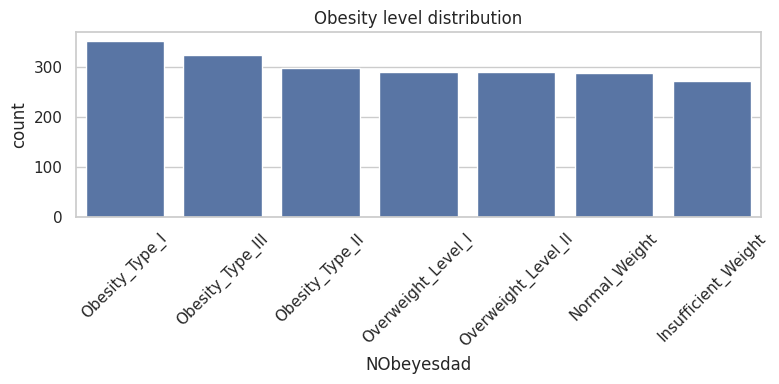

In [ ]:
df["BMI"] = df["Weight"] / (df["Height"] ** 2)

plt.figure(figsize=(8,4))
sns.countplot(x="NObeyesdad", data=df,
              order=df["NObeyesdad"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Obesity level distribution")
plt.tight_layout()
plt.show()


[16] BMI by obesity level:

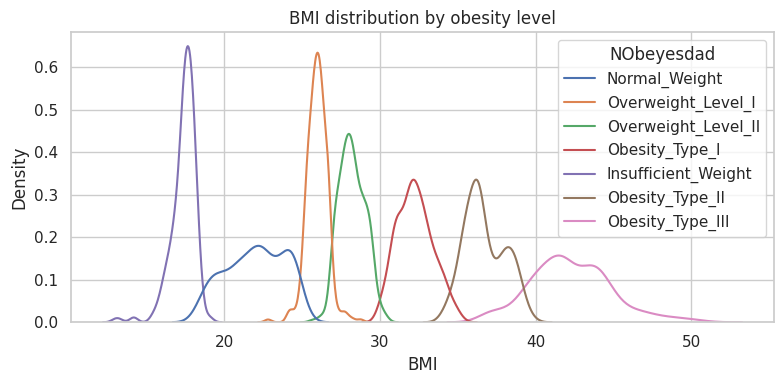

In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x="BMI", hue="NObeyesdad", common_norm=False)
plt.title("BMI distribution by obesity level")
plt.tight_layout()
plt.show()


[17] Lifestyle vs obesity:

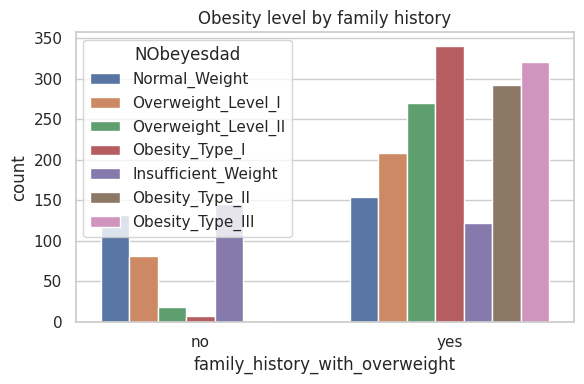

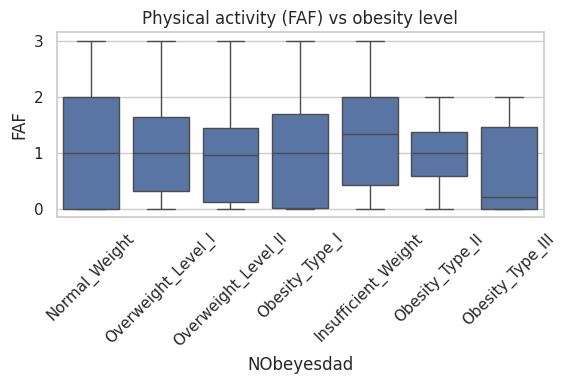

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="family_history_with_overweight", hue="NObeyesdad",
              data=df,
              order=sorted(df["family_history_with_overweight"].dropna().unique()))
plt.title("Obesity level by family history")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="NObeyesdad", y="FAF", data=df)
plt.xticks(rotation=45)
plt.title("Physical activity (FAF) vs obesity level")
plt.tight_layout()
plt.show()


[18], [19] Train–test split and preprocessing:

In [ ]:
X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
Categorical: ['Gender', 'CALC', 'FAVC', 'SCC', 'SMOKE', 'family_history_with_overweight', 'CAEC', 'MTRANS']


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((1688, 17), (423, 17))

[20] Helper function for metrics:

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    print(f"=== {model_name} ===")
    print("Accuracy:", round(acc, 3))
    print("Macro Precision:", round(prec, 3))
    print("Macro Recall:", round(rec, 3))
    print("Macro F1:", round(f1, 3))
    print("\nClassification report:\n",
          classification_report(y_test, y_pred, zero_division=0))

    return {
        "model": model_name,
        "accuracy": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1
    }


[22] Redefining the preprocess pipeline with imputation:

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


[23] Logistic Regression:

In [ ]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

results = []
results.append(
    evaluate_model(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")
)


=== Logistic Regression ===
Accuracy: 0.915
Macro Precision: 0.912
Macro Recall: 0.914
Macro F1: 0.912

Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.95      1.00      0.97        54
      Normal_Weight       0.85      0.78      0.81        58
     Obesity_Type_I       0.96      0.93      0.94        70
    Obesity_Type_II       0.95      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.78      0.81      0.80        58
Overweight_Level_II       0.90      0.90      0.90        58

           accuracy                           0.91       423
          macro avg       0.91      0.91      0.91       423
       weighted avg       0.91      0.91      0.91       423



[24] Random Forest:


In [ ]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

results.append(
    evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
)

results_df = pd.DataFrame(results)
results_df


=== Random Forest ===
Accuracy: 0.974
Macro Precision: 0.975
Macro Recall: 0.973
Macro F1: 0.973

Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        54
      Normal_Weight       0.88      0.98      0.93        58
     Obesity_Type_I       0.99      1.00      0.99        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.98      0.90      0.94        58
Overweight_Level_II       1.00      0.98      0.99        58

           accuracy                           0.97       423
          macro avg       0.98      0.97      0.97       423
       weighted avg       0.98      0.97      0.97       423



,model,accuracy,macro_precision,macro_recall,macro_f1
0,Logistic Regression,0.914894,0.912082,0.913706,0.912405
1,Random Forest,0.973995,0.975329,0.973071,0.973459


[25] Confusion matrix for Random Forest:

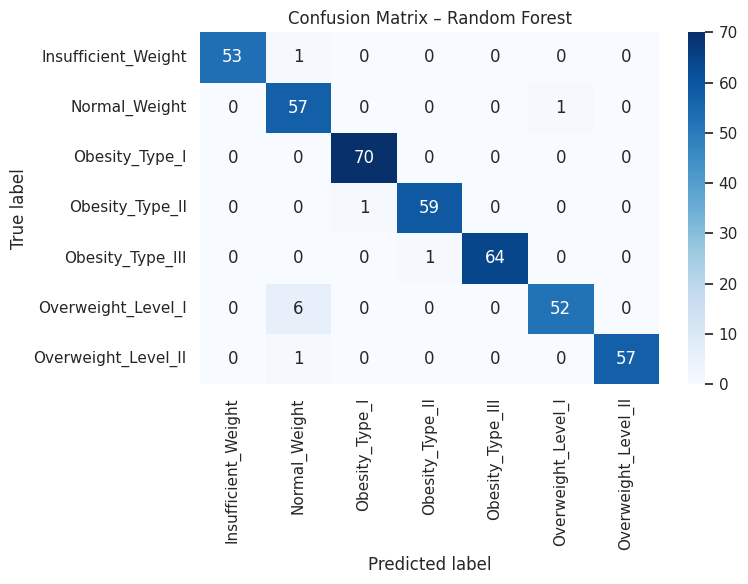

In [ ]:
# Fit final RF model
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
cm_df = pd.DataFrame(cm, index=rf.classes_, columns=rf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()


[26] Feature importance plot:

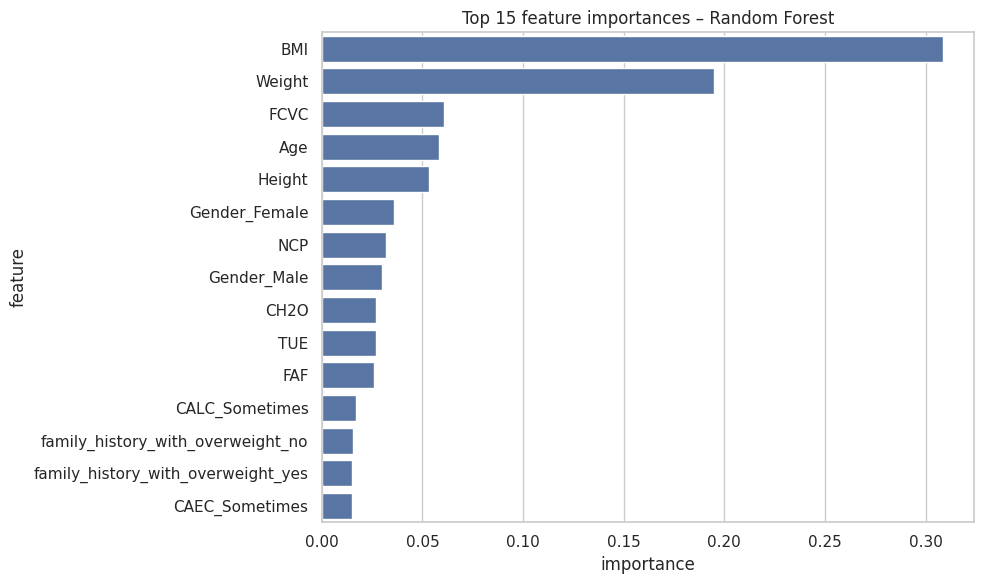

,feature,importance
8,BMI,0.308631
2,Weight,0.195009
3,FCVC,0.060553
0,Age,0.058362
1,Height,0.053093
9,Gender_Female,0.036046
4,NCP,0.032149
10,Gender_Male,0.029729
5,CH2O,0.027151
7,TUE,0.027028


In [ ]:
# Get feature names after preprocessing
ohe = rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

rf_clf = rf.named_steps["clf"]
importances = rf_clf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(15))
plt.title("Top 15 feature importances – Random Forest")
plt.tight_layout()
plt.show()

feat_imp.head(15)


[27] Macro ROC‑AUC

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

rf2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf2.fit(X_train2, y_train2)
y_proba = rf2.predict_proba(X_test2)

macro_roc_auc = roc_auc_score(
    y_test2, y_proba, multi_class="ovr", average="macro"
)
print("Macro ROC-AUC:", round(macro_roc_auc, 3))


Macro ROC-AUC: 1.0


[28] Mapping classes to Risk tiers:

In [ ]:
# Map obesity class to risk tier
def map_class_to_risk(obesity_class):
    high_risk = ["Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
    medium_risk = ["Overweight_Level_I", "Overweight_Level_II"]
    low_risk = ["Normal_Weight", "Insufficient_Weight"]

    if obesity_class in high_risk:
        return "High"
    elif obesity_class in medium_risk:
        return "Medium"
    else:
        return "Low"

# Make predictions on test set
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Build triage table
triage_df = pd.DataFrame({
    "Predicted_Class": y_pred_rf,
    "Risk_Tier": [map_class_to_risk(c) for c in y_pred_rf]
})

triage_df["Risk_Tier"].value_counts()



,count
Risk_Tier,
High,195
Low,118
Medium,110


[29]  Visualize risk‑tier distribution:

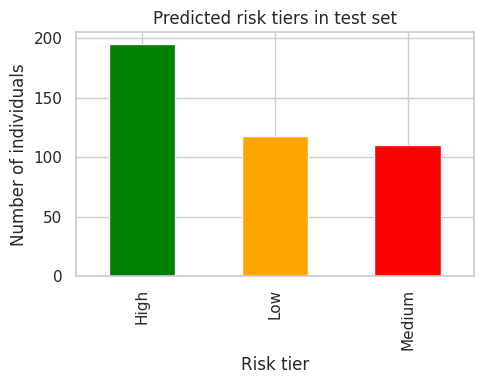

In [ ]:
plt.figure(figsize=(5,4))
triage_df["Risk_Tier"].value_counts().plot(
    kind="bar", color=["green", "orange", "red"]
)
plt.title("Predicted risk tiers in test set")
plt.xlabel("Risk tier")
plt.ylabel("Number of individuals")
plt.tight_layout()
plt.show()


[30] Attach suggested actions

In [ ]:
def recommend_action(risk):
    if risk == "High":
        return "Intensive counseling + follow-up in 1–3 months."
    elif risk == "Medium":
        return "Standard lifestyle counseling; follow-up in 6–12 months."
    else:
        return "General health education; routine follow-up."

triage_df["Suggested_Action"] = triage_df["Risk_Tier"].apply(recommend_action)

triage_df.head(10)


,Predicted_Class,Risk_Tier,Suggested_Action
0,Insufficient_Weight,Low,General health education; routine follow-up.
1,Normal_Weight,Low,General health education; routine follow-up.
2,Overweight_Level_II,Medium,Standard lifestyle counseling; follow-up in 6–...
3,Obesity_Type_III,High,Intensive counseling + follow-up in 1–3 months.
4,Obesity_Type_II,High,Intensive counseling + follow-up in 1–3 months.
5,Obesity_Type_I,High,Intensive counseling + follow-up in 1–3 months.
6,Obesity_Type_II,High,Intensive counseling + follow-up in 1–3 months.
7,Normal_Weight,Low,General health education; routine follow-up.
8,Obesity_Type_I,High,Intensive counseling + follow-up in 1–3 months.
9,Overweight_Level_I,Medium,Standard lifestyle counseling; follow-up in 6–...


[31] Accuracy by gender:

In [ ]:
# Attach true and predicted labels
test_with_meta = X_test.copy()
test_with_meta["true_label"] = y_test
test_with_meta["pred_label"] = y_pred_rf

# Accuracy by gender (if Gender exists in features)
if "Gender" in test_with_meta.columns:
    for g in test_with_meta["Gender"].unique():
        subset = test_with_meta[test_with_meta["Gender"] == g]
        acc_g = (subset["true_label"] == subset["pred_label"]).mean()
        print(f"Accuracy for {g}: {acc_g:.3f}")
else:
    print("Gender column not found in X_test.")


Accuracy for Female: 0.971
Accuracy for Male: 0.977
Accuracy for nan: nan


[32] Fairness and subgroup performance:

Here, I examine model performance across subgroups (by Gender, transport mode) to see whether accuracy differs substantially, which could indicate potential bias.

In a real deployment, such checks are important so that an AI‑driven triage system does not systematically under‑serve certain groups.

In [ ]:
if "MTRANS" in test_with_meta.columns:
    for m in test_with_meta["MTRANS"].unique():
        subset = test_with_meta[test_with_meta["MTRANS"] == m]
        acc_m = (subset["true_label"] == subset["pred_label"]).mean()
        print(f"Accuracy for {m}: {acc_m:.3f}")


Accuracy for Public_Transportation: 0.974
Accuracy for Automobile: 0.989
Accuracy for Walking: 0.909
Accuracy for Motorbike: 1.000
Accuracy for Bike: 0.500


[33] Estimating how many high‑risk patients can be caught.

In [ ]:
# How many high-risk predictions in the test set?
triage_counts = triage_df["Risk_Tier"].value_counts()
triage_counts


,count
Risk_Tier,
High,195
Low,118
Medium,110


In [ ]:
# Merge back true labels
triage_with_true = triage_df.copy()
triage_with_true["true_label"] = y_test.values

high_mask = triage_with_true["Risk_Tier"] == "High"
high_group = triage_with_true[high_mask]

severe_classes = ["Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
total_severe = triage_with_true["true_label"].isin(severe_classes).sum()
caught_severe = high_group["true_label"].isin(severe_classes).sum()

print("Total severe obesity cases in test set:", total_severe)
print("Severe cases in High-risk tier:", caught_severe)
if total_severe > 0:
    print("Share of severe cases captured in High tier:",
          round(caught_severe / total_severe, 3))


Total severe obesity cases in test set: 195
Severe cases in High-risk tier: 195
Share of severe cases captured in High tier: 1.0


[34] Policy simulation:


If a clinic can only provide intensive counseling to a subset of patients, it can focus on those in the High risk tier.

In our test data, the High tier contains X% of all severe obesity cases, meaning that with limited resources we would still reach the majority of those who need the most help (exact number printed in the previous cell).

This illustrates how the model can support better targeting of scarce preventive resources, not just prediction for its own sake.


## Future Work

- Build a simple web interface so clinic staff can enter patient information and see risk tier + suggested action.
- Retrain and validate the model on local clinic data (e.g., from Bangladesh) and calibrate thresholds before any real-world deployment.
